In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import mta_functions

In [2]:
# Load in mta 2018 pickle file
mta_data = pd.read_pickle('mta_2018')

In [3]:
#  Fix EXITS column name
mta_data.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [4]:
# Create DateTime column
mta_data['DATETIME'] = pd.to_datetime(mta_data.DATE + ' ' + mta_data.TIME)
mta_data['DATE']= pd.to_datetime(mta_data['DATE'])

In [5]:
# Convert Date object to Datetime
mta_data['DATE']= pd.to_datetime(mta_data['DATE'])

In [6]:
# Create Weekday from newly create DateTime column
mta_data['WEEKDAY'] = mta_data['DATETIME'].dt.day_name()

In [7]:
# Identify Daytime
mta_data['DAYTYPE'] = mta_data['WEEKDAY'].apply(lambda x: 'WEEKEND' if x == 'Sunday' else 'WEEKDAY')

In [8]:
# Create ID for each turnstile
mta_data['UNIQUEID'] = mta_data['STATION'] + '_' + mta_data['UNIT'] + '_' + mta_data['C/A'] + '_' + mta_data['SCP']

In [9]:
# Create Time of Day
mta_data['TIMEOFDAY'] = mta_data['DATETIME'].dt.hour

In [10]:
# Daily Counts by Turnstile
mta_data['ENTRYDIFF'] = mta_data['ENTRIES'].diff()
mta_data['EXITDIFF'] = mta_data['EXITS'].diff()

In [11]:
mta_data['DURATION'] = mta_data.DATETIME.diff().apply(lambda x: x.total_seconds()/3600)

In [12]:
# Drop Rows without changes
mta_data.dropna(subset=['ENTRYDIFF', 'EXITDIFF'], inplace=True)

In [13]:
# Drop First Entry Per Turnstile
mta_data = mta_data[mta_data.DATETIME >= mta_data.DATE.min() + pd.DateOffset(days=1)]

In [14]:
# Normalize floats to int values
mta_data['ENTRYDIFF'] = mta_data['ENTRYDIFF'].astype(int)
mta_data['EXITDIFF'] = mta_data['EXITDIFF'].astype(int)
mta_data['TRAFFIC'] = mta_data['ENTRYDIFF'] + mta_data['EXITDIFF']

In [15]:
mta_data['AVG_TRAFFIC'] = mta_data['TRAFFIC'] / mta_data['DURATION']

In [16]:
# Drop ENTRYDIFF AND EXITDIFF Rows with extreme values
mta_data = mta_data[mta_data.ENTRYDIFF <= 10000]
mta_data = mta_data[mta_data.ENTRYDIFF > 0]
mta_data = mta_data[mta_data.EXITDIFF <= 10000]
mta_data = mta_data[mta_data.EXITDIFF > 0]

In [17]:
# Export pickle of processed mta data
mta_data.to_pickle(f'mta_data_processed')

Retreive Top Stations

In [18]:
# Group traffic values by station and date
top_traffic_stations_df = mta_data.groupby(['STATION','DATE','WEEKDAY'], as_index=False).TRAFFIC.sum().sort_values('TRAFFIC', ascending=False)
top_traffic_stations_df

,STATION,DATE,WEEKDAY,TRAFFIC
1583,34 ST-PENN STA,2018-05-16,Wednesday,330617
1584,34 ST-PENN STA,2018-05-17,Thursday,329526
1582,34 ST-PENN STA,2018-05-15,Tuesday,326203
1591,34 ST-PENN STA,2018-05-24,Thursday,324384
1598,34 ST-PENN STA,2018-05-31,Thursday,322755
...,...,...,...,...
9471,V.CORTLANDT PK,2018-05-13,Sunday,2
7539,MORRIS PARK,2018-05-20,Sunday,2
9267,SUTTER AV-RUTLD,2018-05-28,Monday,2
9266,SUTTER AV-RUTLD,2018-05-27,Sunday,2


In [19]:
# Create pivots tables
top_traffic_stations_wide = mta_data.groupby(['STATION','DATE'], as_index=False).TRAFFIC.sum().sort_values('TRAFFIC', ascending=False).pivot("DATE", "STATION", "TRAFFIC")

In [20]:
# Generate list of top stations
top_count = 10
top_stations_list = mta_functions.topStations(top_traffic_stations_wide, top_count)

In [21]:
# Filter by stations with top counts
top_traffic_stations_df = top_traffic_stations_df[top_traffic_stations_df.STATION.isin(top_stations_list)]

In [22]:
# Export top stations
# top_traffic_stations_df.to_csv('top_traffic_stations.csv')
top_traffic_stations_df

,STATION,DATE,WEEKDAY,TRAFFIC
1583,34 ST-PENN STA,2018-05-16,Wednesday,330617
1584,34 ST-PENN STA,2018-05-17,Thursday,329526
1582,34 ST-PENN STA,2018-05-15,Tuesday,326203
1591,34 ST-PENN STA,2018-05-24,Thursday,324384
1598,34 ST-PENN STA,2018-05-31,Thursday,322755
...,...,...,...,...
1218,23 ST,2018-05-27,Sunday,56839
1219,23 ST,2018-05-28,Monday,56584
5981,FULTON ST,2018-05-19,Saturday,56417
5975,FULTON ST,2018-05-13,Sunday,53720


Weekly Averages by Station

In [23]:
top_traffic_stations_weekday_average = top_traffic_stations_df.groupby(['STATION','WEEKDAY'], as_index=False).TRAFFIC.mean().sort_values('TRAFFIC', ascending=False)
top_traffic_stations_weekday_average

,STATION,WEEKDAY,TRAFFIC
32,34 ST-PENN STA,Thursday,324769.500000
34,34 ST-PENN STA,Wednesday,322133.750000
33,34 ST-PENN STA,Tuesday,318157.000000
28,34 ST-PENN STA,Friday,308197.000000
76,GRD CNTRL-42 ST,Wednesday,292492.750000
...,...,...,...
45,59 ST COLUMBUS,Sunday,67618.500000
17,23 ST,Sunday,66296.000000
44,59 ST COLUMBUS,Saturday,65462.666667
65,FULTON ST,Saturday,63649.666667


In [24]:
# Sort by weekday
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
wc = pd.CategoricalDtype(categories=weekdays, ordered=True)
top_traffic_stations_weekday_average['WEEKDAY'] = top_traffic_stations_weekday_average['WEEKDAY'].astype(wc)
top_traffic_stations_weekday_average

,STATION,WEEKDAY,TRAFFIC
32,34 ST-PENN STA,Thursday,324769.500000
34,34 ST-PENN STA,Wednesday,322133.750000
33,34 ST-PENN STA,Tuesday,318157.000000
28,34 ST-PENN STA,Friday,308197.000000
76,GRD CNTRL-42 ST,Wednesday,292492.750000
...,...,...,...
45,59 ST COLUMBUS,Sunday,67618.500000
17,23 ST,Sunday,66296.000000
44,59 ST COLUMBUS,Saturday,65462.666667
65,FULTON ST,Saturday,63649.666667


In [25]:
top_stations_weekday_averages_wide = top_traffic_stations_weekday_average.pivot("WEEKDAY", "STATION", "TRAFFIC")
top_stations_weekday_averages_wide

STATION,125 ST,14 ST-UNION SQ,23 ST,34 ST-HERALD SQ,34 ST-PENN STA,42 ST-PORT AUTH,59 ST COLUMBUS,86 ST,CANAL ST,FULTON ST,GRD CNTRL-42 ST,TIMES SQ-42 ST
WEEKDAY,,,,,,,,,,,,
Sunday,81649.000000,116040.750000,66296.000000,89017.500000,140852.750000,100503.50,67618.500000,75790.75,85381.500000,57401.000000,88458.000000,114900.500000
Monday,118415.000000,167355.250000,151554.250000,171222.250000,262541.750000,139395.75,109685.750000,128825.25,115576.000000,151408.750000,220220.250000,161897.500000
Tuesday,136397.250000,194062.000000,199996.000000,215163.000000,318157.000000,161733.75,134011.500000,157158.25,128507.000000,187829.500000,286082.500000,193845.750000
Wednesday,139575.750000,204228.750000,207842.000000,221094.000000,322133.750000,165132.75,137842.750000,161507.75,130979.500000,192645.000000,292492.750000,203049.500000
Thursday,138972.750000,201316.250000,206242.500000,221530.750000,324769.500000,164160.25,136825.750000,160885.50,132545.250000,192512.750000,282708.250000,203841.250000
Friday,141573.000000,200265.750000,191903.500000,216720.750000,308197.000000,161645.75,131066.750000,157251.75,132760.000000,180504.000000,252453.500000,198413.500000
Saturday,79436.333333,121074.333333,68879.333333,84768.333333,138490.666667,98462.00,65462.666667,75881.00,94411.666667,63649.666667,93060.666667,110635.666667


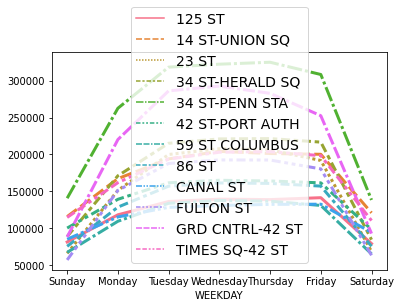

In [26]:
top_stations_weekly_averages = sns.lineplot(data=top_stations_weekday_averages_wide, linewidth = 3)
top_stations_weekly_averages.legend(fontsize='14')
sns.set(rc={'figure.figsize':(12,6)})
top_stations_weekly_averages.get_figure().savefig('top_stations_weekly_averages.svg', format='svg')
top_stations_weekly_averages;

Retrieve POI Stations

In [27]:
poi_list = ['116 ST-COLUMBIA','14 ST','34 ST-PENN STA','5 AVE','68ST-HUNTER CO','ASTOR PL','CANAL ST','CORTLANDT ST','JAY ST-METROTEC']
poi_stations_df = mta_data[mta_data.STATION.isin(poi_list)]
poi_stations_df = poi_stations_df.groupby(['STATION','DATE','WEEKDAY'], as_index=False).TRAFFIC.sum().sort_values('TRAFFIC', ascending=False)
# poi_stations_df.to_csv('poi_stations.csv')

In [28]:
targets_df = poi_stations_df[poi_stations_df.STATION.isin(top_stations_list)]
# targets_df.to_csv('target_stations.csv')

Line Plots for select Stations

In [29]:
def hourlyLinePlots(station):
    filtered_station = mta_data[mta_data.STATION == station]

    filtered_station_weekdays_df = filtered_station[filtered_station.DAYTYPE == 'WEEKDAY']
    filtered_station_weekdays_df = filtered_station_weekdays_df.groupby(['DATE', 'TIMEOFDAY', 'WEEKDAY'], as_index=False).TRAFFIC.sum().sort_values('TRAFFIC', ascending=False)
    filtered_station_weekdays_df = filtered_station_weekdays_df.groupby(['TIMEOFDAY'], as_index=False).TRAFFIC.mean().sort_values('TRAFFIC', ascending=False)

    filtered_station_weekends_df = filtered_station[filtered_station.DAYTYPE == 'WEEKEND']
    filtered_station_weekends_df = filtered_station_weekends_df.groupby(['DATE', 'TIMEOFDAY', 'WEEKDAY'], as_index=False).TRAFFIC.sum().sort_values('TRAFFIC', ascending=False)
    filtered_station_weekends_df = filtered_station_weekends_df.groupby(['TIMEOFDAY'], as_index=False).TRAFFIC.mean().sort_values('TRAFFIC', ascending=False)

    ax = sns.lineplot(x='TIMEOFDAY', y='TRAFFIC', data=filtered_station_weekdays_df, label='weekday')
    ax = sns.lineplot(x='TIMEOFDAY', y='TRAFFIC', data=filtered_station_weekends_df, label='weekend')
    ax.set_title(f'{station} station')
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Traffic')

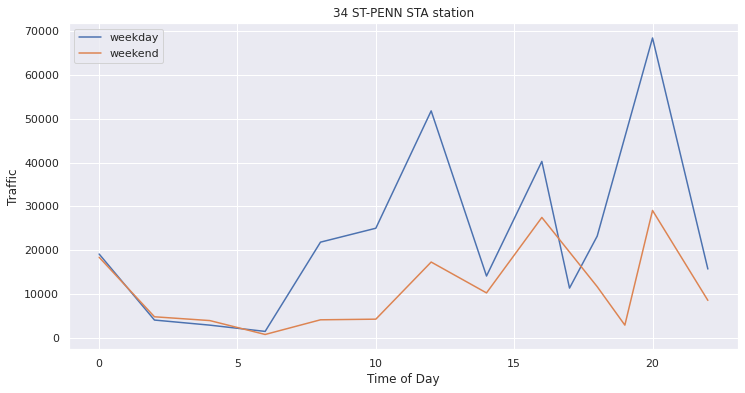

In [30]:
hourlyLinePlots('34 ST-PENN STA')

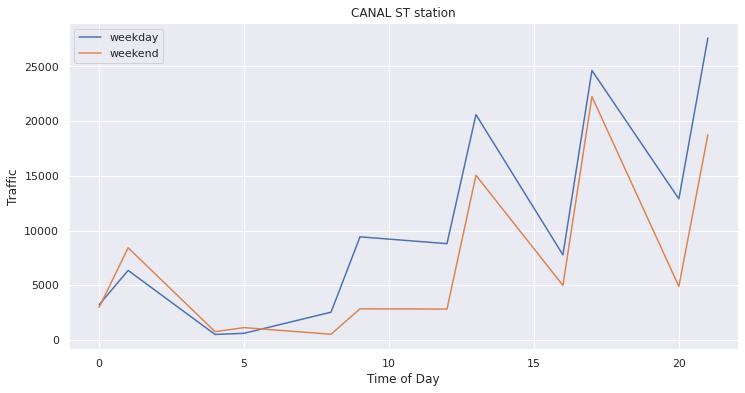

In [31]:
hourlyLinePlots('CANAL ST')

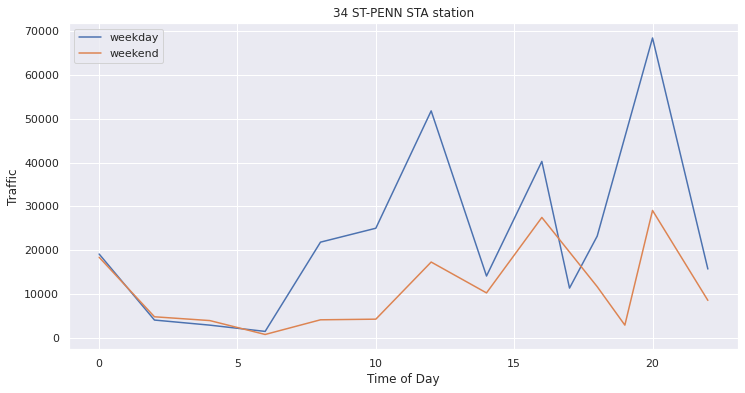

In [32]:
hourlyLinePlots('34 ST-PENN STA')

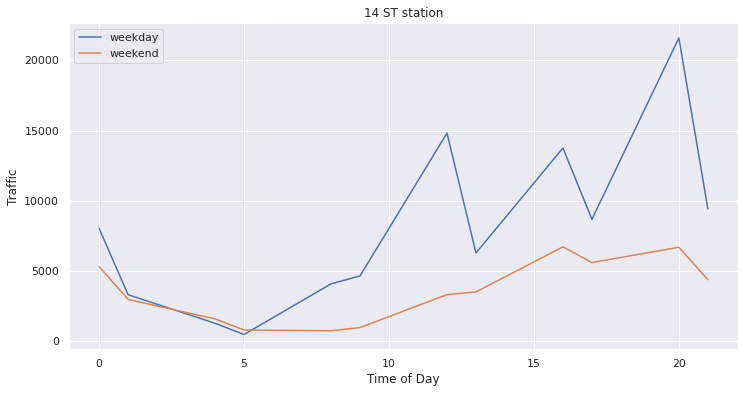

In [33]:
hourlyLinePlots('14 ST')

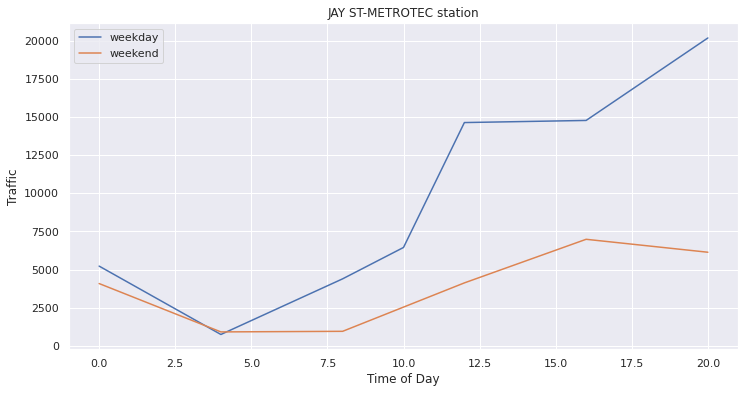

In [37]:
hourlyLinePlots('JAY ST-METROTEC')